### Goal: To learn about Markov Logic Networks
[Markov Logic Networks](https://cacm.acm.org/magazines/2019/7/237715-unifying-logical-and-statistical-ai-with-markov-logic/fulltext)


In [ ]:
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from itertools import product

## Markov Logic Networks:
#### A Markov logic network (MLN) is a set of weighted first-order formulas, viewed as templates for constructing Markov networks.
#### Markov network (also known as Markov random field) represents a joint probability distribution over variables X = {X1, X2, ..., Xn} as a product of factors (also known as potential functions):
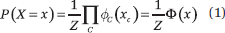

#### where each C is a nonnegative, real-valued function defined over variables X$_C$ ⊂ X and Z is a normalization constant known as the partition function. For convenience, we also define Φ(x) as the unnormalized probability distribution, the product of all potential functions. A Markov network can be represented as a graph with one node per variable and an undirected edge between any two variables that appear together in the same factor.

#### Markov networks are often conveniently represented as log-linear models, with each potential function replaced by an exponentiated weighted sum of features of the state, leading to

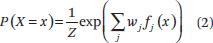

### Formal Definition 
#### A Markov logic network (MLN) L is a set of pairs (F$_i$, w$_i$), where F$_i$ is a formula in first-order logic and w$_i$ is a real number. Together with a finite set of constants C = {c$_1$, c$_2$, ..., c$_|$$_c$$_|$}, it defines a Markov network M$_L$$,$$_C$ (Equations 1 and 2) as follows:

M$_L$$,$$_C$ contains one random variable for each possible grounding of each atom appearing in L. The value of the variable is true if the ground atom is true and false otherwise.

M$_L$$,$$_C$ contains one feature for each possible grounding of each formula F$_i$ in L. The value of this feature is 1 if the ground formula is true and 0 otherwise. The weight of the feature is the wi associated with F$_i$ in L.

#### Define First Order Logic representation
##### Define weights and predicates
##### Assumptions: 
 - weight= 1.5 predicate: ∀x, smokes(x) => cancer(x)
 - weight= 1.1 predicate: ∀x,y friends(x,y) => ( smokes(x) ⇔ cancer(x) )

##### Ground Atoms:
Alice (A) and Bob (B)
Smokes(A), Smokes(B), Cancer(A), Cancer(B)
Friends(A,B) Friends(B,A) Friends(A,A) Friends(B,B)

### Example
 - Smoking causes cancer
 - Friends have similar habits

#### Constants C = {c$_1$, c$_2$, ..., c$_|$$_c$$_|$}

In [ ]:
constants = ['A', 'B']
predicates = [('Smokes', 1), ('Cancer', 1), ('Friends', 2)]

In [ ]:
ground_atoms = [ 
                (p, *args) 
                for p, arity in predicates
                for args in product(constants, repeat=arity)]
print("*****************Ground Atoms**************888")
print(ground_atoms)

*****************Ground Atoms**************888
[('Smokes', 'A'), ('Smokes', 'B'), ('Cancer', 'A'), ('Cancer', 'B'), ('Friends', 'A', 'A'), ('Friends', 'A', 'B'), ('Friends', 'B', 'A'), ('Friends', 'B', 'B')]


#### L: set of formula weight pairs

In [ ]:
formulas = [
            ([('Smokes',(0,)), ('Cancer',(0,))], [1,0], 1, 1.5 ),
            ([('Friends', (0,1)), ('Smokes',(0,)), ('Smokes',(1,))], [ 1, 0, 1], 2, 1.1),
            ([('Friends', (0,1)), ('Smokes',(0,)), ('Smokes',(1,))], [ 1, 1, 0], 2, 1.1),
]
formulas

[([('Smokes', (0,)), ('Cancer', (0,))], [1, 0], 1, 1.5),
 ([('Friends', (0, 1)), ('Smokes', (0,)), ('Smokes', (1,))],
  [1, 0, 1],
  2,
  1.1),
 ([('Friends', (0, 1)), ('Smokes', (0,)), ('Smokes', (1,))],
  [1, 1, 0],
  2,
  1.1)]

In [ ]:
grounded_formulas = []
for clauses, neg, arity, w in formulas:
  for args in product(constants, repeat=arity):
    ground_formula = [
        (p, *map(lambda i: args[i], v))
        for p,v in clauses
    ]
    grounded_formulas.append((ground_formula, neg, w))

In [ ]:
print("****************Grounded Formulas**********************")
print(grounded_formulas)

****************Grounded Formulas**********************
[([('Smokes', 'A'), ('Cancer', 'A')], [1, 0], 1.5), ([('Smokes', 'B'), ('Cancer', 'B')], [1, 0], 1.5), ([('Friends', 'A', 'A'), ('Smokes', 'A'), ('Smokes', 'A')], [1, 0, 1], 1.1), ([('Friends', 'A', 'B'), ('Smokes', 'A'), ('Smokes', 'B')], [1, 0, 1], 1.1), ([('Friends', 'B', 'A'), ('Smokes', 'B'), ('Smokes', 'A')], [1, 0, 1], 1.1), ([('Friends', 'B', 'B'), ('Smokes', 'B'), ('Smokes', 'B')], [1, 0, 1], 1.1), ([('Friends', 'A', 'A'), ('Smokes', 'A'), ('Smokes', 'A')], [1, 1, 0], 1.1), ([('Friends', 'A', 'B'), ('Smokes', 'A'), ('Smokes', 'B')], [1, 1, 0], 1.1), ([('Friends', 'B', 'A'), ('Smokes', 'B'), ('Smokes', 'A')], [1, 1, 0], 1.1), ([('Friends', 'B', 'B'), ('Smokes', 'B'), ('Smokes', 'B')], [1, 1, 0], 1.1)]


#### Generate the all possible worlds
#### M$_L$$,$$_C$

In [ ]:
# Generate the all possible worlds
X = pd.DataFrame(columns=ground_atoms, data=list(product([1,0], repeat=len(ground_atoms))))
X.head()

,"(Smokes, A)","(Smokes, B)","(Cancer, A)","(Cancer, B)","(Friends, A, A)","(Friends, A, B)","(Friends, B, A)","(Friends, B, B)"
0,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,0
2,1,1,1,1,1,1,0,1
3,1,1,1,1,1,1,0,0
4,1,1,1,1,1,0,1,1


#### An MLN can be viewed as a template for constructing Markov networks. From Definition 1 and Equations 1 and 2, the probability distribution over possible worlds x specified by the ground Markov network ML, C is given by

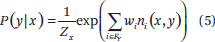

In [ ]:
S = np.zeros(len(X))
for f, neg, w in grounded_formulas:
  S += w * np.logical_xor(X[f], neg).any(1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
#partition function
logZ = logsumexp(S)

In [ ]:
#joint probability
joint_probability = X.copy()
joint_probability['logP'] = S - logZ
print("***********Joint Probability*********************")
print(joint_probability)

***********Joint Probability*********************
     (Smokes, A)  (Smokes, B)  ...  (Friends, B, B)      logP
0              1            1  ...                1 -4.809774
1              1            1  ...                0 -4.809774
2              1            1  ...                1 -4.809774
3              1            1  ...                0 -4.809774
4              1            1  ...                1 -4.809774
..           ...          ...  ...              ...       ...
251            0            0  ...                0 -4.809774
252            0            0  ...                1 -4.809774
253            0            0  ...                0 -4.809774
254            0            0  ...                1 -4.809774
255            0            0  ...                0 -4.809774

[256 rows x 9 columns]


In [ ]:
print("*********P(Friends(A,B))****************")
P_Friends_AB = np.exp(joint_probability.groupby([('Friends', 'A', 'B')])['logP'].agg(logsumexp))
print(P_Friends_AB)

*********P(Friends(A,B))****************
(Friends, A, B)
0    0.570909
1    0.429091
Name: logP, dtype: float64



#### Discriminative learning optimizes our ability to predict the query atoms Y given the evidence X. A common approach is to maximize the conditional likelihood of Y given X, and F$_i$ is set of all MLN formulas with at least one grounding involving a query atom, and n$_i$ (x, y) is the number of true groundings of the ith formula involving query atoms
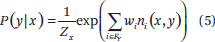

In [ ]:
print("*********P(Friends(A,B)|Smokes(A))****************")
P_Friends_AB_SmA = np.exp(joint_probability.groupby([('Smokes','A'),('Friends', 'A', 'B')])['logP'].agg(logsumexp))
P_SmA = np.exp(joint_probability.groupby([('Smokes','A')])['logP'].agg(logsumexp))
print(P_Friends_AB_SmA/P_SmA)

*********P(Friends(A,B)|Smokes(A))****************
(Smokes, A)  (Friends, A, B)
0            0                  0.553456
             1                  0.446544
1            0                  0.605285
             1                  0.394715
Name: logP, dtype: float64


In [ ]:
len(joint_probability)

256